# Analiza sieci tramwajowej w Poznaniu

Przedmiotem analizy jest sieć tramwajowa w Poznaniu. Dane o przejazdach pozyskaliśmy samodzielnie ze strony ZTM: https://www.ztm.poznan.pl/pl/rozklad-jazdy/ przy użyciu skryptu skrapującego. Dane o lokalizacji przystanków pozyskaliśmy ręcznie z Google Maps, ponieważ nigdzie niestety takie dane nie były dostępne.

### Pytania o charakterze biznesowym:
* Które części miasta mogą cierpieć z powodu nierozbudowanej sieci tramwajowej?
* Które węzły są w sieci najważniejsze z punktu widzenia ewentualnego wyłączenia z użycia?

## 0. Importy

In [1]:
import networkx as nx
import pprint
from typing import Mapping, List, Tuple
import matplotlib.pyplot as plt
import numpy as np

## 1. Wczytanie danych

In [2]:
def read_routes() -> Mapping[str, List]:
    routes = {}
    
    trams = list(range(1, 19)) + [201]
    for tram in trams:
        stops = None
        with open(f'./data/{tram}there') as f:
            stops = f.read().splitlines()
            stops = [s.strip() for s in stops]
        routes[f"{tram}there"] = stops

        with open(f'./data/{tram}back') as f:
            stops = f.read().splitlines()
            stops = [s.strip() for s in stops]
        routes[f"{tram}back"] = stops
    return routes

def read_coords() -> Mapping[str, Tuple]:
    result = {}
    with open(f'./data/coords') as f:
        lines = f.read().splitlines()
        for line in lines:
            line = line.strip()
            stop_name, x, y  = line.split(",")
            result[stop_name] = (float(y.strip()), float(x.strip()))
    return result

In [3]:
route_to_stops : Mapping[str, List] = read_routes()

In [4]:
stop_to_location : Mapping[str, Tuple] = read_coords()

In [5]:
# just to check if we have all coords
for r, stops in route_to_stops.items():
    for stop in stops:
        if stop not in stop_to_location:
            print(stop)

## 2. Utworzenie skierowanego Multigrafu

In [6]:
G = nx.MultiDiGraph()

# Adding nodes (stops)
for stop_name, coords in stop_to_location.items():
    G.add_node(stop_name, location=coords)

# Adding directed edges (between each pair of stops on a route)
for k, stops_list in route_to_stops.items():
    edges = [(stops_list[i],stops_list[i+1]) for i in range(len(stops_list)-1)]
    G.add_edges_from(edges, route=k, color=np.random.rand(3,)) # assign some random color to a route

In [7]:
# list(G)

### Narysowany graf (bez etykiet)

In [8]:
route_color = {}

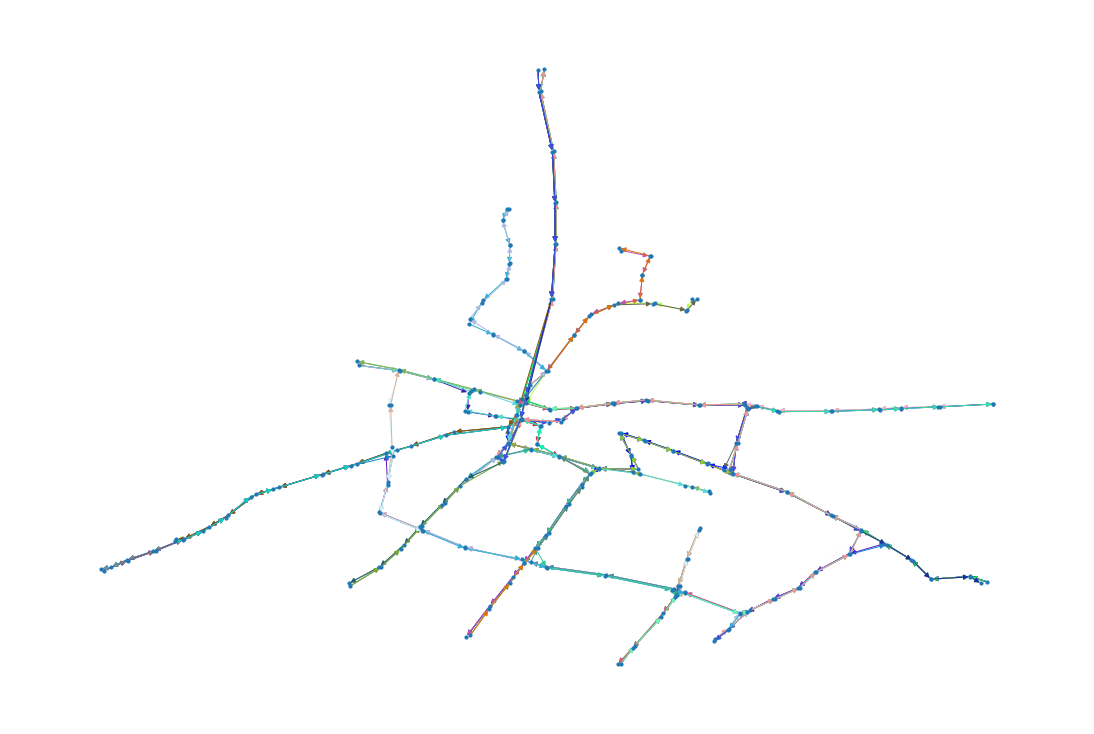

In [9]:
plt.figure(figsize=(15,10))
colors = nx.get_edge_attributes(G,'color').values()
nx.draw(G, nx.get_node_attributes(G, 'location'), with_labels=False, node_size=10, edge_color=colors)

### Rozkład stopni wyjściowych i wejściowych

### Rozkład długości najkrótszych ścieżek

### Rozkład pośrednictwa

### Rozkład lokalnych współczynników grupowania

### Miary oceny sieci: gęstość, współczynnik centralizacji, promień 

### Podział sieci na moduły

### Trzy wizualizacje